In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta']


##  Data reading

In [3]:
run         = 'Run27'
run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 10
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 30


In [4]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_dir)[:5]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [5]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes,
                                             sample_binning = sample_binning
                                             )  
        dataframes.append(df)

Reading .bin files:   0%|          | 0/23 [00:00<?, ?file/s]

Reading .bin files: 100%|██████████| 23/23 [00:48<00:00,  2.11s/file]


In [6]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

In [7]:
df = merged_df
df.tail()

TIME       CH1       CH2         CH3         CH4         CH5  \
8647995  0.000006  3.184636  3.371830 -369.254395  -71.383774 -409.831482   
8647996  0.000006  3.062150  3.678360 -369.438721  -89.858856 -409.831482   
8647997  0.000006  2.572206  3.923584 -370.114563 -113.367012 -409.278473   
8647998  0.000006  2.817178  3.862278 -369.500153 -144.854446 -409.401367   
8647999  0.000006  2.694692  3.187912 -369.500153 -174.254974 -409.954376   

                CH6         CH7         CH8         CH9        CH10  event  \
8647995 -648.934875 -349.238342 -679.959839 -408.760529 -581.711731  11499   
8647996 -644.334656 -348.870209 -681.554504 -408.575989 -578.582275  11499   
8647997 -643.291992 -348.992920 -674.869019 -408.760529 -569.562073  11499   
8647998 -648.628174 -349.238342 -666.404785 -408.883545 -556.921509  11499   
8647999 -650.468262 -349.115631 -661.313965 -409.252655 -547.533142  11499   

           event_time  file_idx  
8647995  566769144915        22  
8647996  566769144915        22  
8647997  566769144915        22  
8647998  566769144915        22  
8647999  566769144915        22

##  Data selection

In [8]:
# Filter for a specific event (change index as needed)
event_list  = df['event'].unique()
nevents     = len(event_list)
print(f'Unfiltered df nevents = {nevents}')

Unfiltered df nevents = 11500


In [9]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp


all_channels    = noAmp_channels + Amp_channels


In [10]:
selected_event = 230
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event


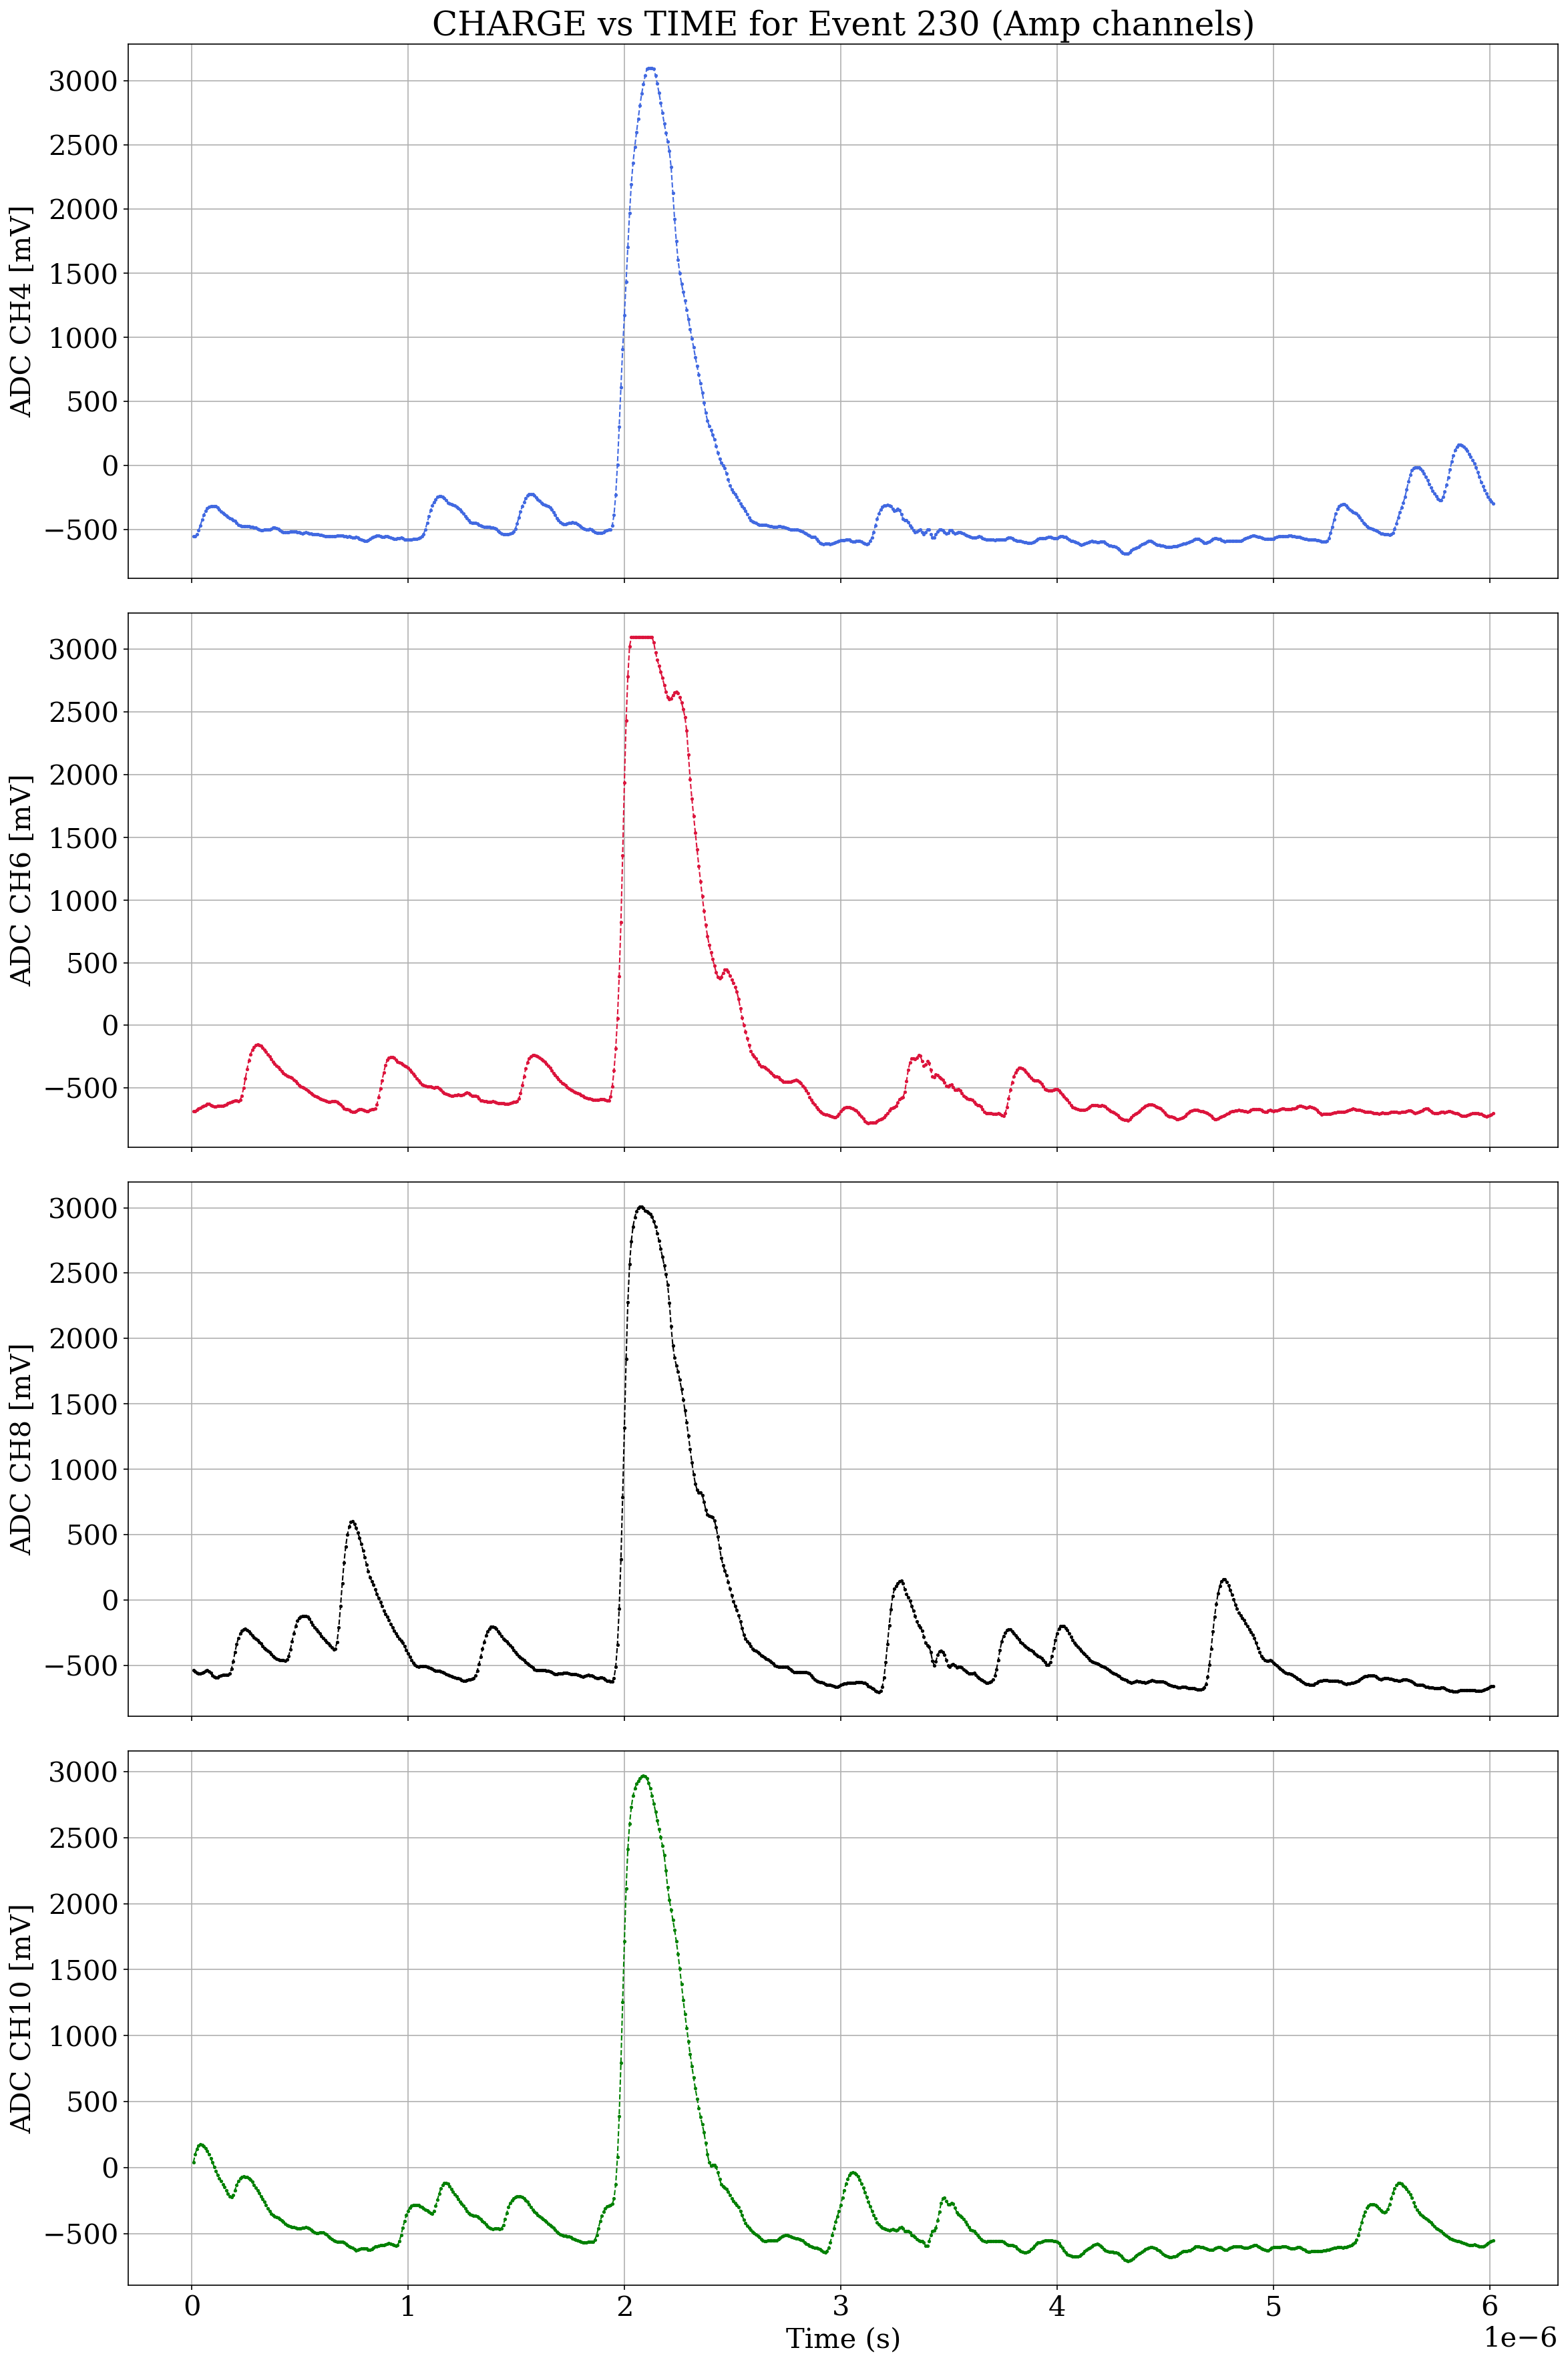

In [11]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]} (Amp channels)')

else:
    ax.set_title(f'CHARGE vs TIME for Event {event_list[selected_event]} (Amp channels)')

# Plot CHs
for i in range(len(Amp_channels)):

    if len(Amp_channels) > 1:
        ax = axs[i]

    ax.plot(df_event['TIME'].values, df_event[f'{Amp_channels[i]}'].values, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{Amp_channels[i]}')
    ax.set_ylabel(f'ADC {Amp_channels[i]} [mV]')
    ax.grid(True)

if len(Amp_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')
# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Data filtering

In [12]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, threshold=1000):
    peak_count = 0
    for ch in Amp_channels:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts = df.groupby("event").apply(count_high_peaks)

# keep only events with <= 5 peaks above 2000
valid_events = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = df[df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)
print(f'Filtered df nevents = {nevents}')

/tmp/ipykernel_370079/1341809093.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts = df.groupby("event").apply(count_high_peaks)


Filtered df nevents = 6013


##  Baseline calculation

In [ ]:
# DEFINITION OF THE BASELINE WINDOW WITH HERE
window_width = 80


In [13]:
selected_ev = 200


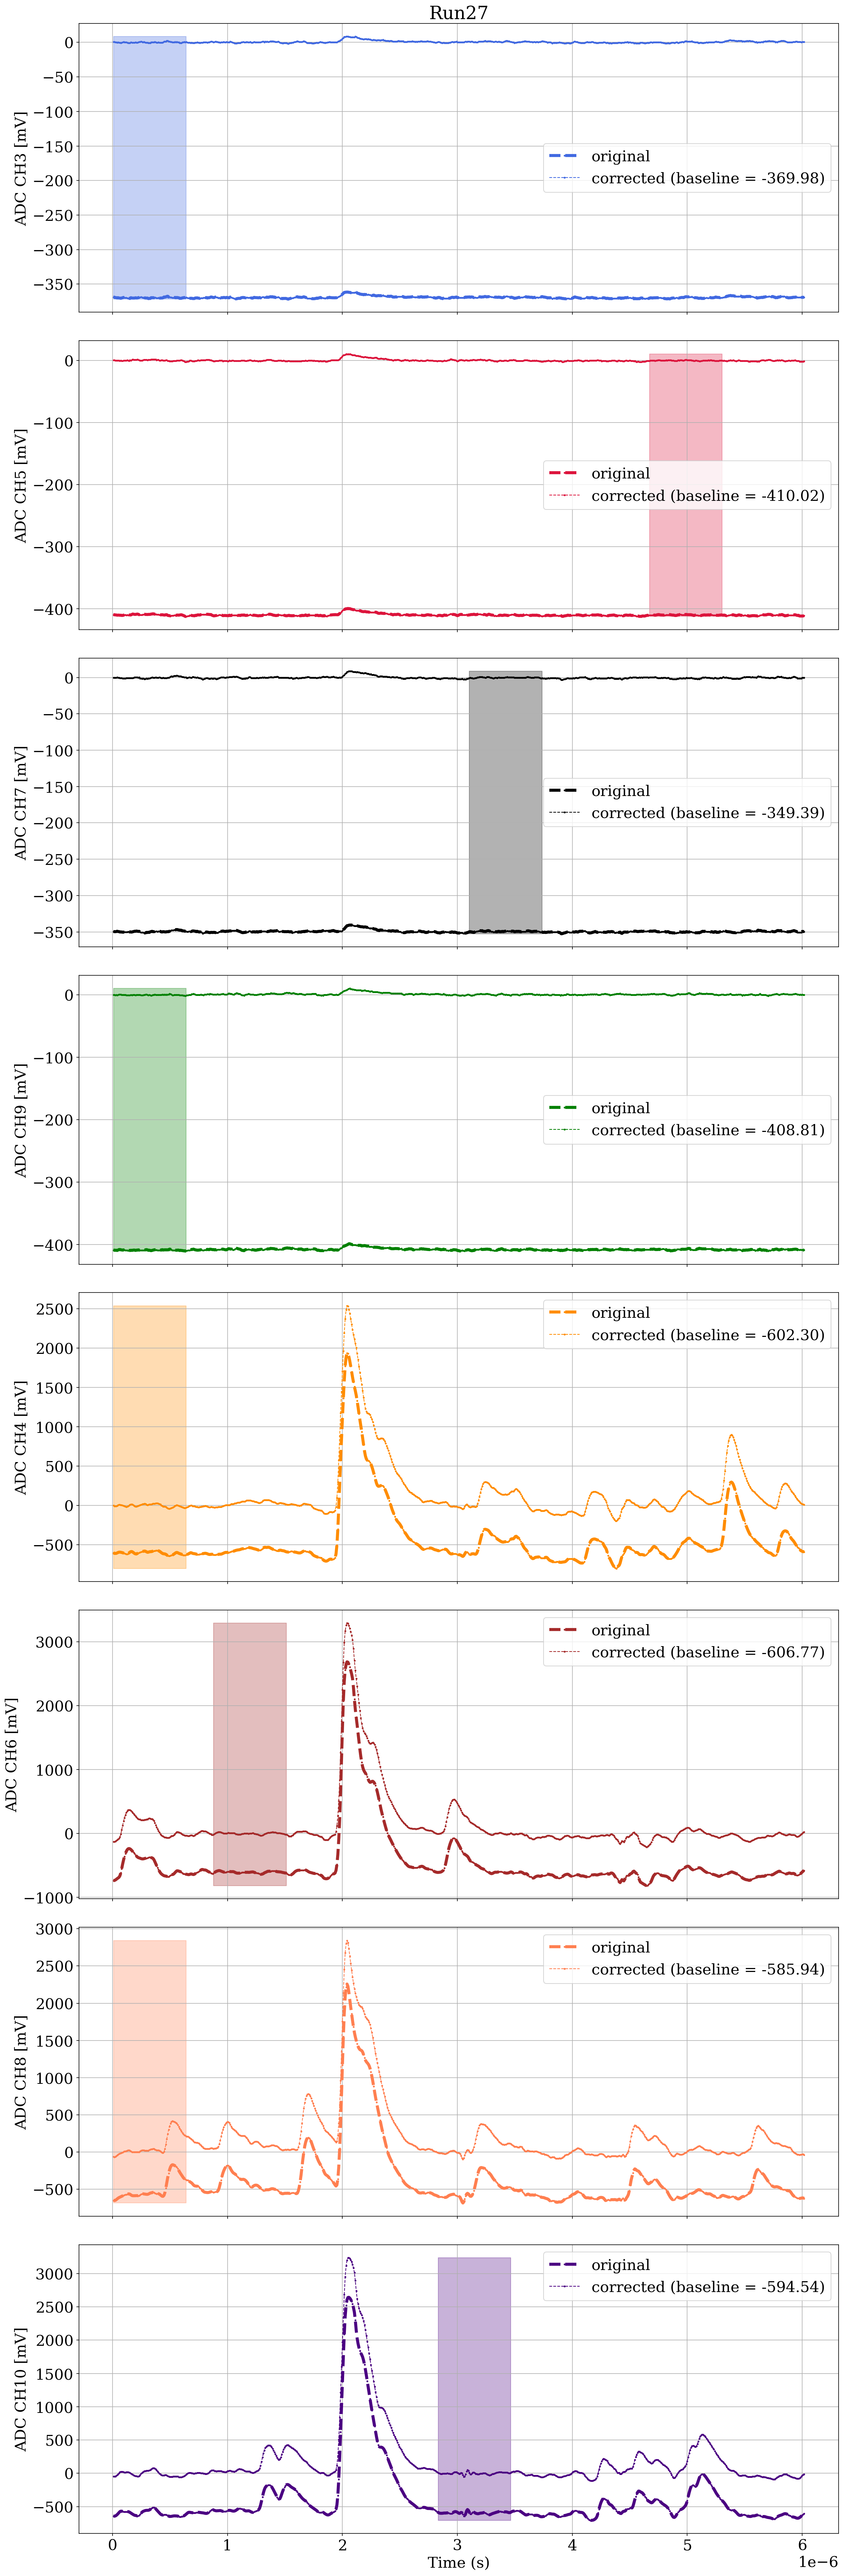

In [ ]:
# Create subplots: 2 rows, 1 column

if len(all_channels) > 1:
    fig, axs = plt.subplots(len(all_channels), 1, figsize=(16, len(all_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(all_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(all_channels):

    if len(all_channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{all_channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_ev], v_matrix[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=4, label=f'original')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected (baseline = {baselines[selected_ev]:.2f})')
    

    start = max(window[selected_ev], 0)
    end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    ax.fill_between(time[start:end], 
                    min(v_matrix_corrected[selected_ev].min(), v_matrix[selected_ev].min()), 
                    max(v_matrix_corrected[selected_ev].max(), v_matrix[selected_ev].max()), 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

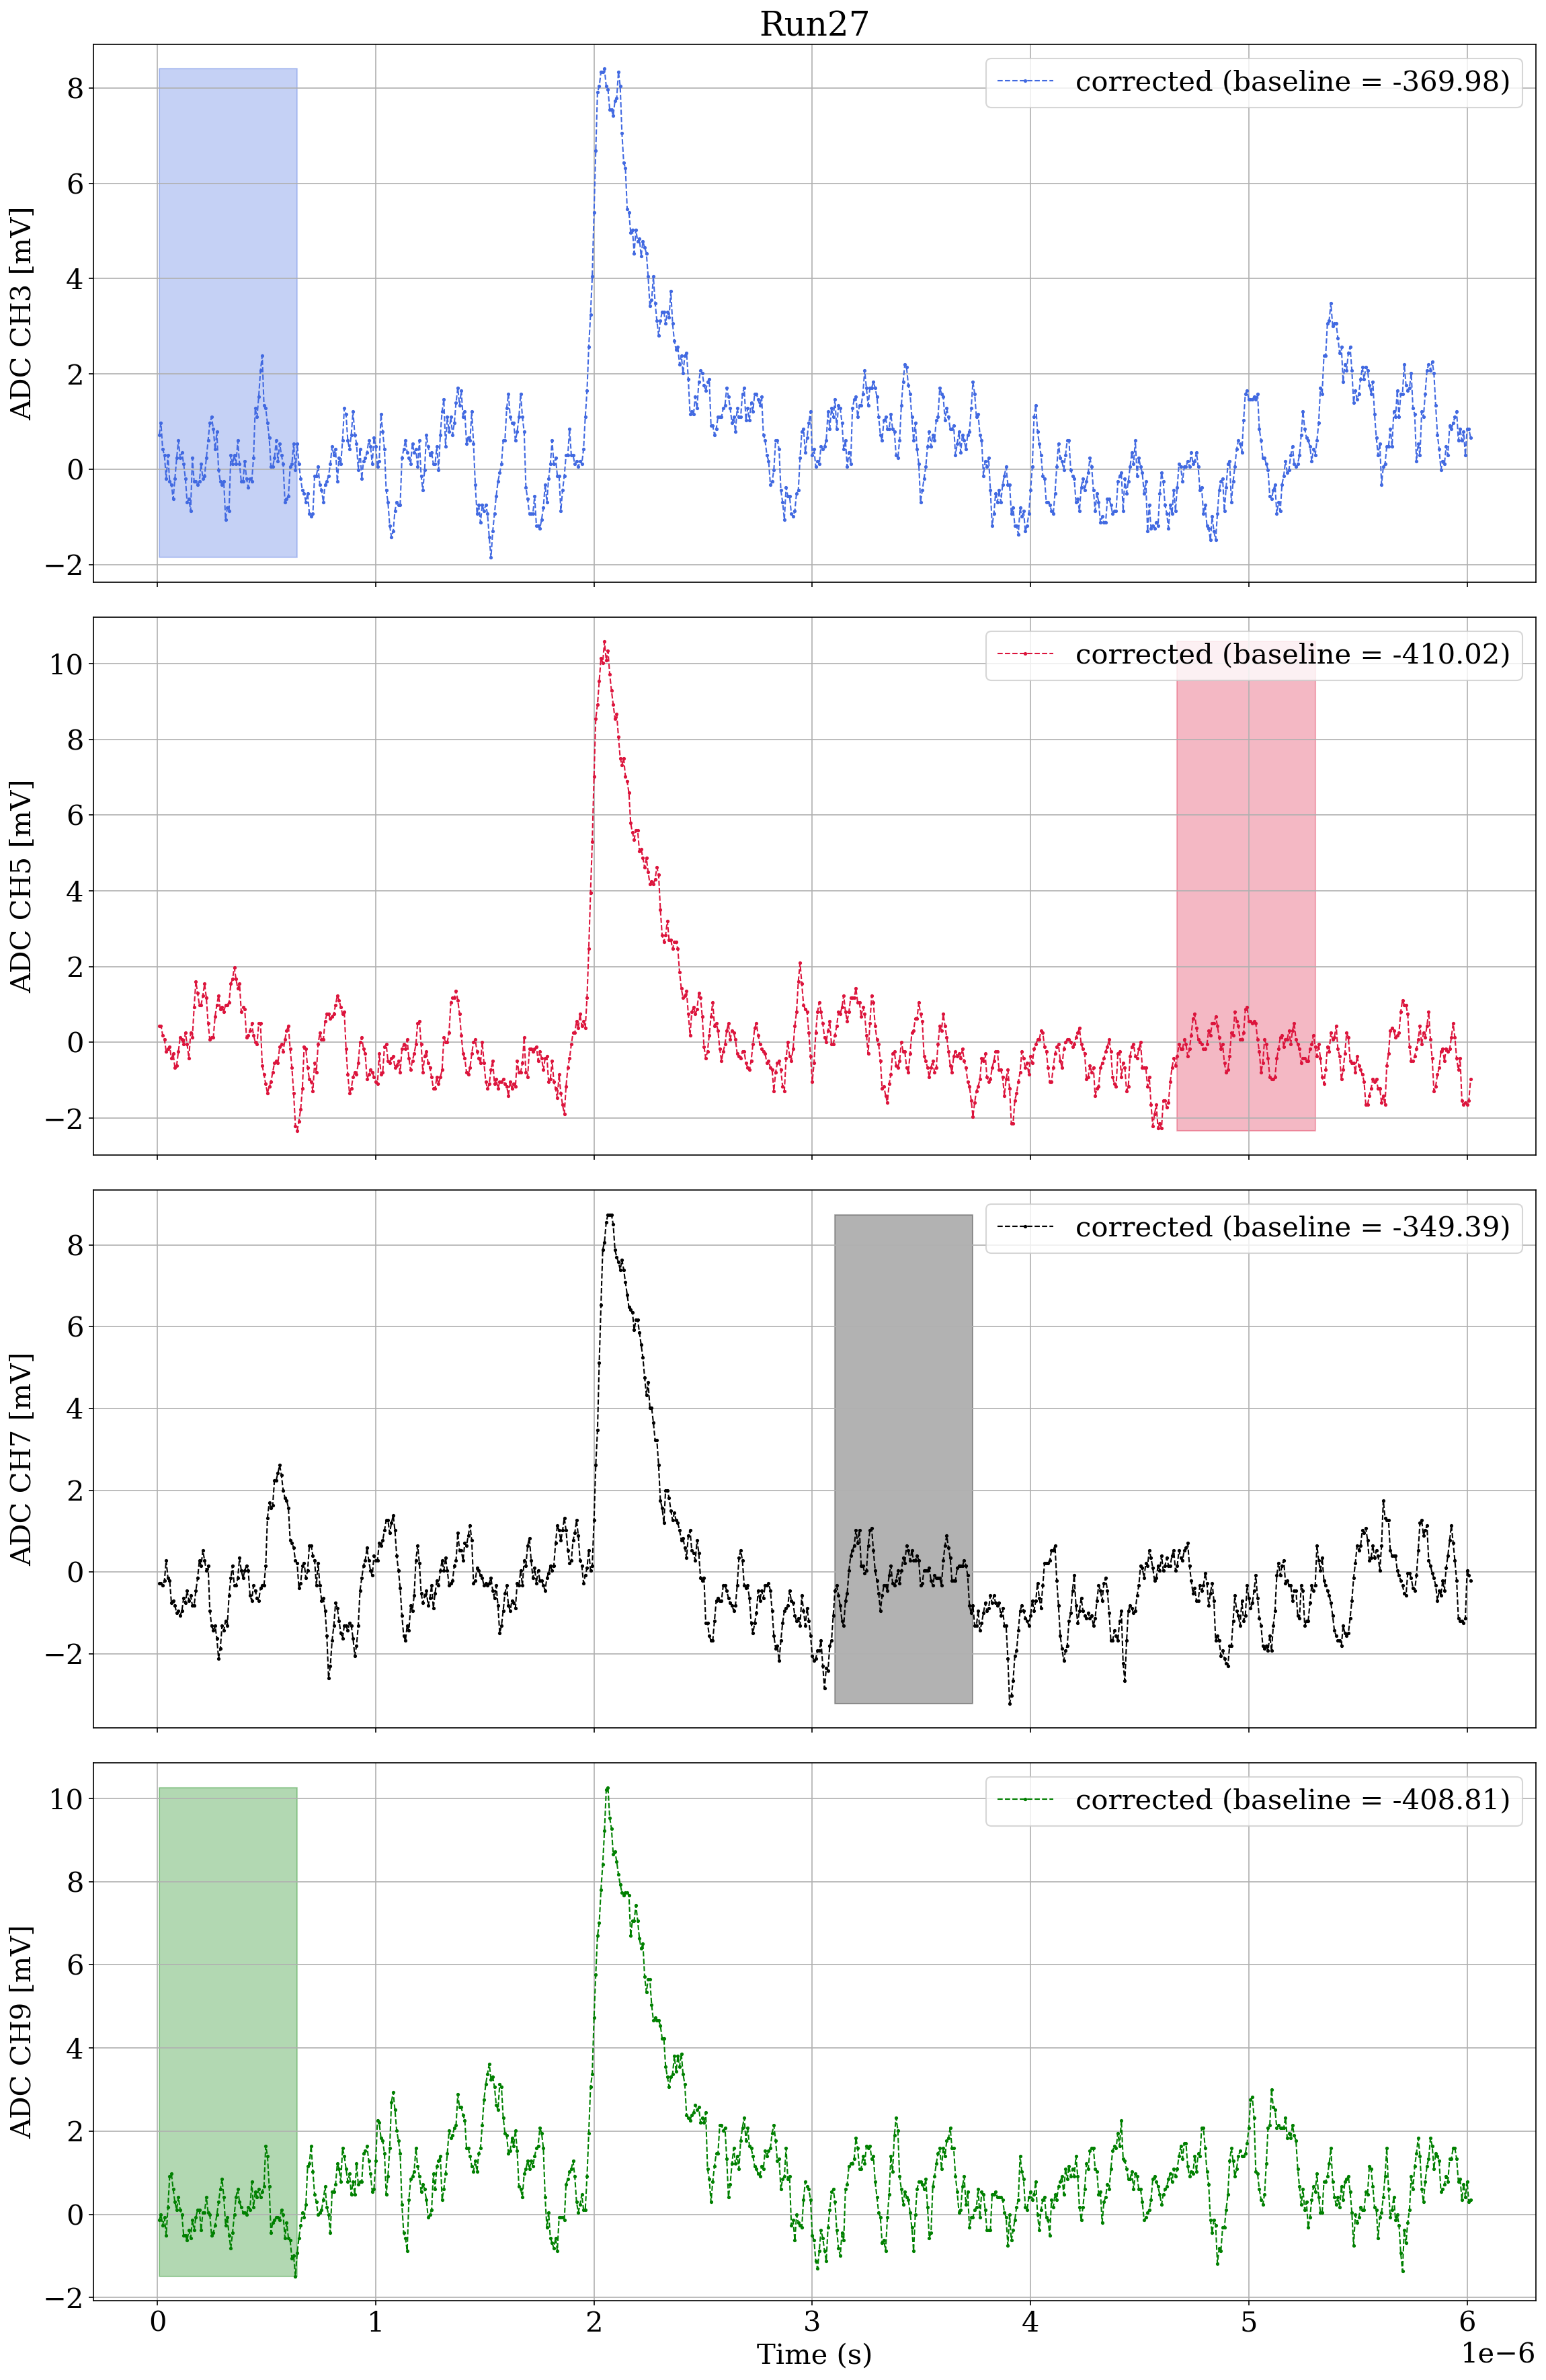

In [ ]:
# Create subplots: 2 rows, 1 column

if len(noAmp_channels) > 1:
    fig, axs = plt.subplots(len(noAmp_channels), 1, figsize=(16, len(noAmp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(noAmp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(noAmp_channels):

    if len(noAmp_channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{noAmp_channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected (baseline = {baselines[selected_ev]:.2f})')
    

    start = max(window[selected_ev], 0)
    end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    ax.fill_between(time[start:end], 
                    v_matrix_corrected[selected_ev].min(), 
                    v_matrix_corrected[selected_ev].max(), 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Amplification

In [14]:
t_matrix = filtered_df['TIME'].values.reshape(nevents, -1)
time = t_matrix[0]

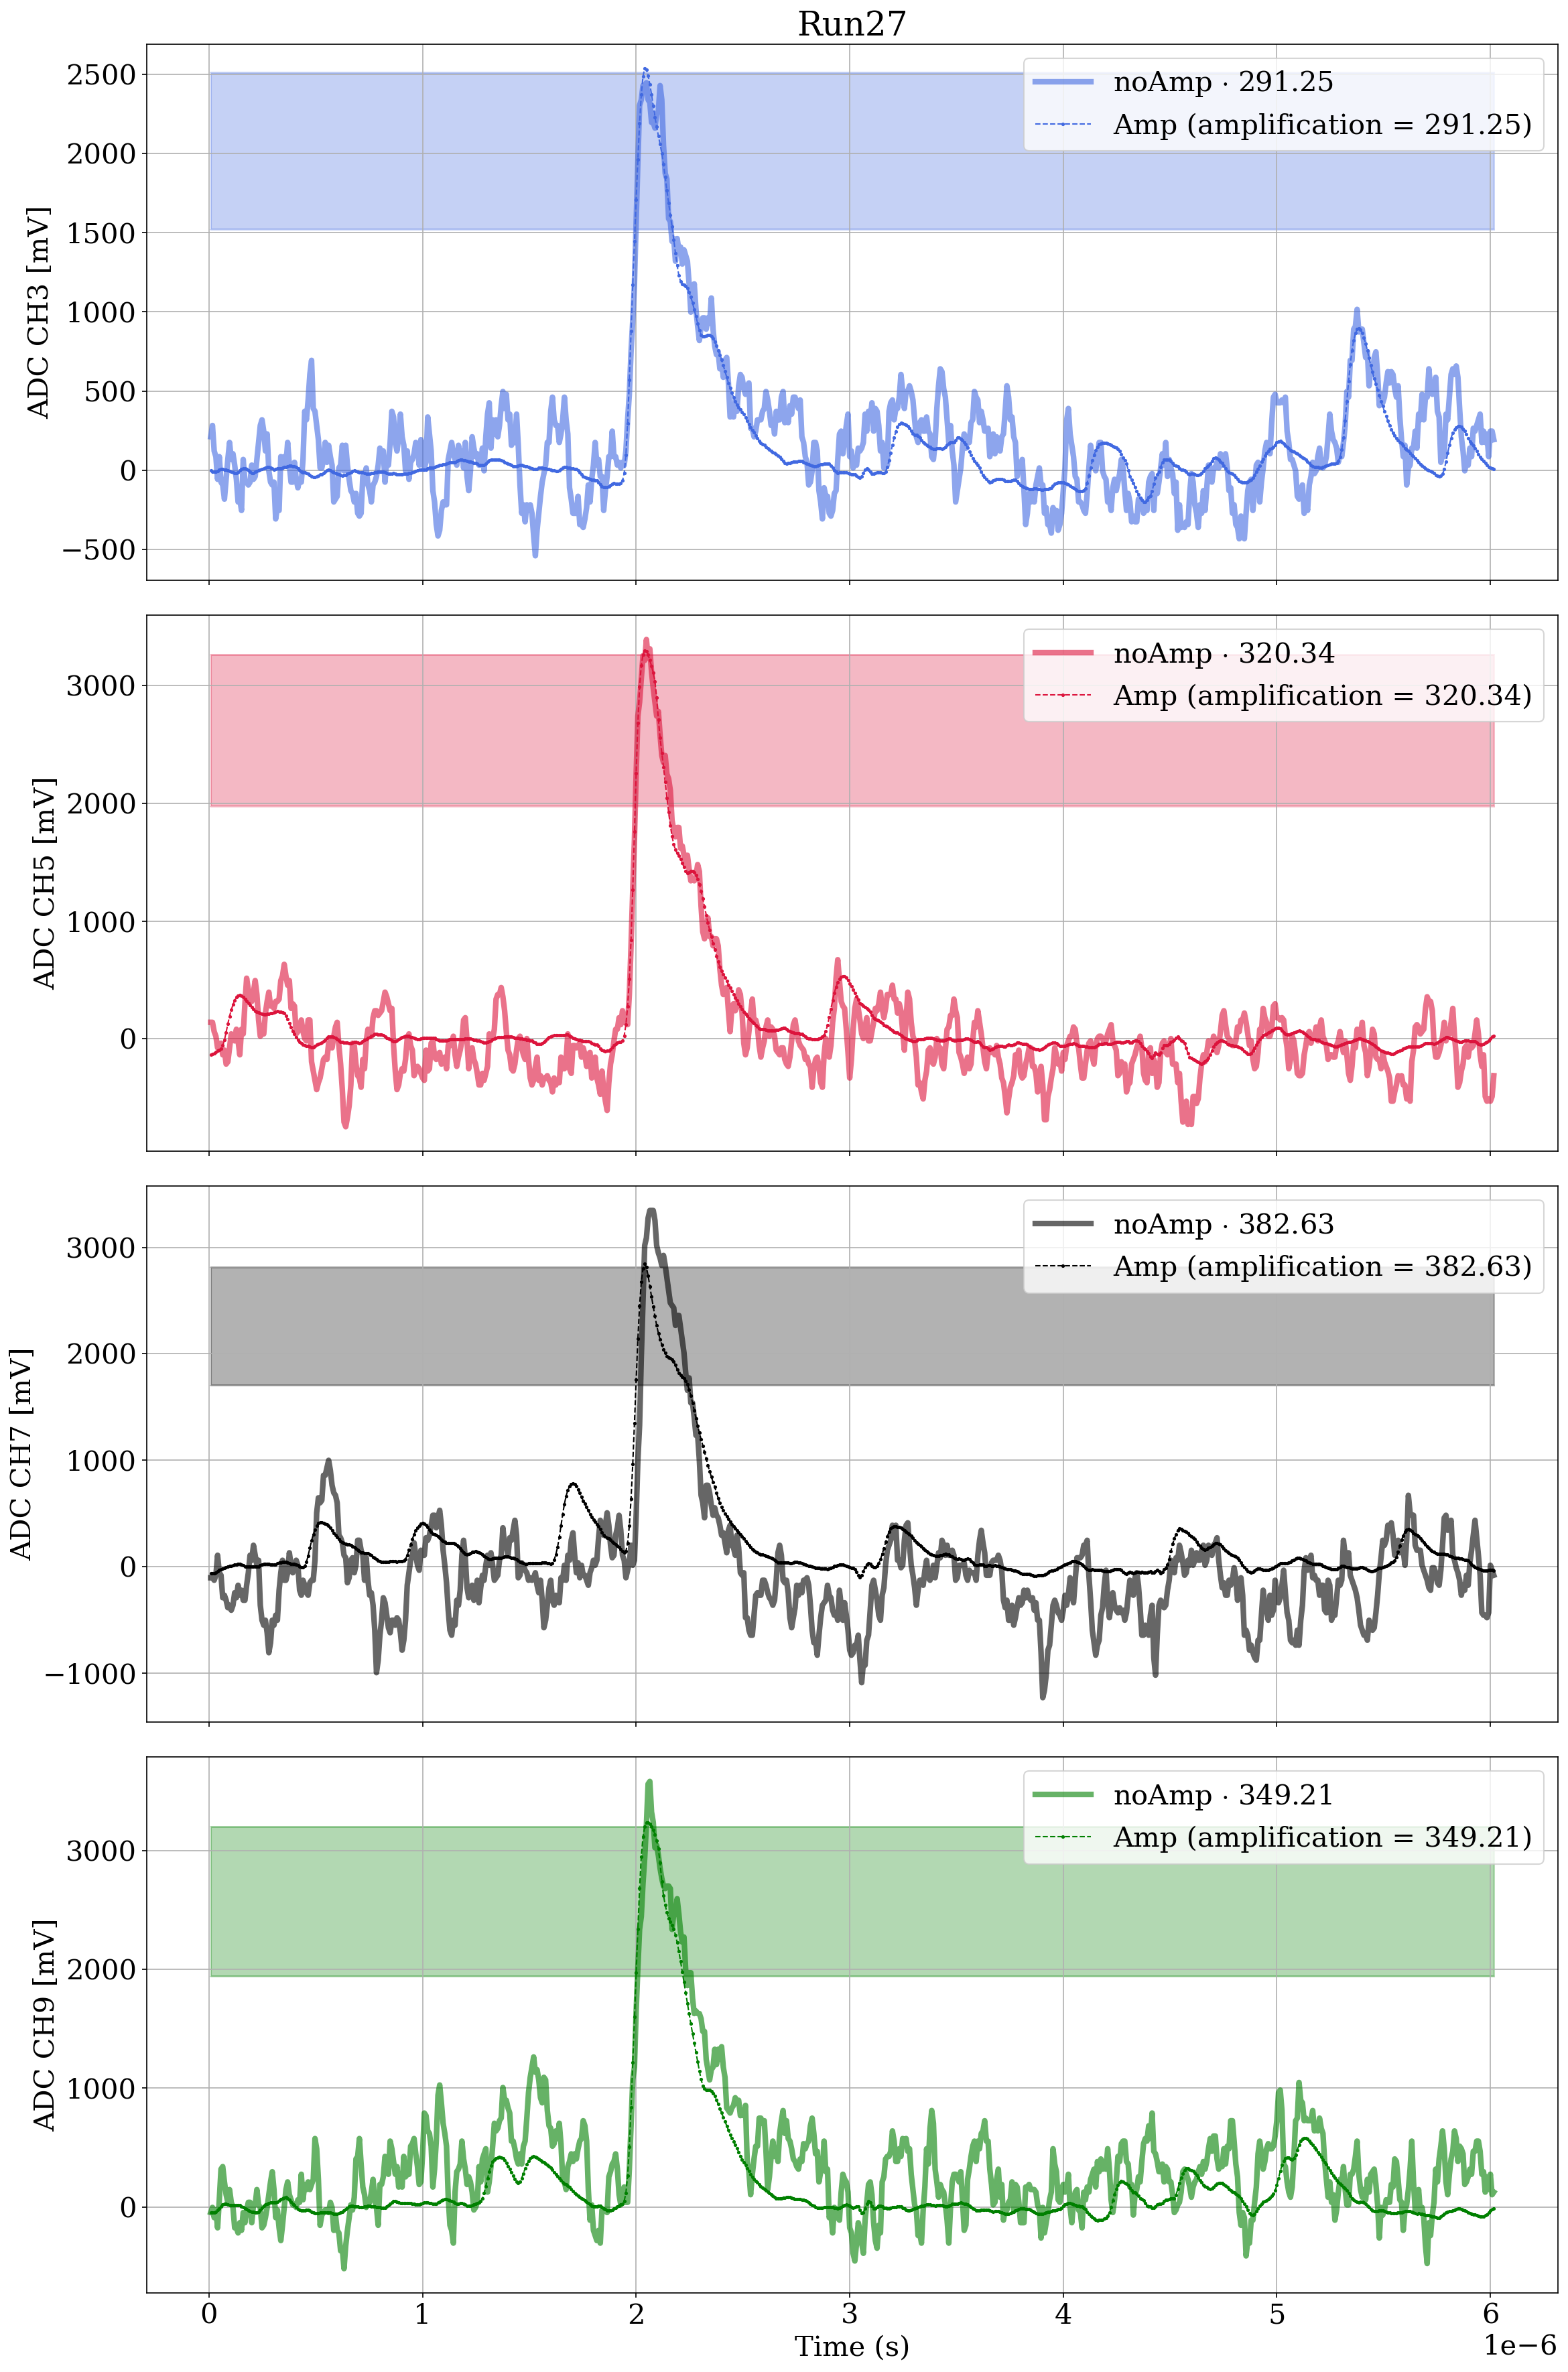

In [ ]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    Amp_min_th      = v_matrix_corrected_Amp[selected_ev].max()*0.6
    Amp_saturation  = v_matrix_corrected_Amp[selected_ev].max()*0.99

    amp_mask    = (v_matrix_corrected_Amp[selected_ev] > Amp_min_th) & (v_matrix_corrected_Amp[selected_ev] < Amp_saturation) # don't get saturation values either
    # Avoid division by zero or tiny denominators
    safe_mask = np.abs(v_matrix_corrected_noAmp[selected_ev]) > 1e-6
    valid_mask = amp_mask & safe_mask

    amp         = (v_matrix_corrected_Amp[selected_ev][valid_mask]/v_matrix_corrected_noAmp[selected_ev][valid_mask]).mean()
    # amp = np.nanmean(v_matrix_corrected_Amp/v_matrix_corrected_noAmp, axis = 1).mean()

    ax.plot(t_matrix[selected_ev], amp*v_matrix_corrected_noAmp[selected_ev], marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, label=fr'noAmp $\cdot$ {amp:.2f}')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected_Amp[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'Amp (amplification = {amp:.2f})')
    

    ax.fill_between(time, Amp_min_th, Amp_saturation, 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

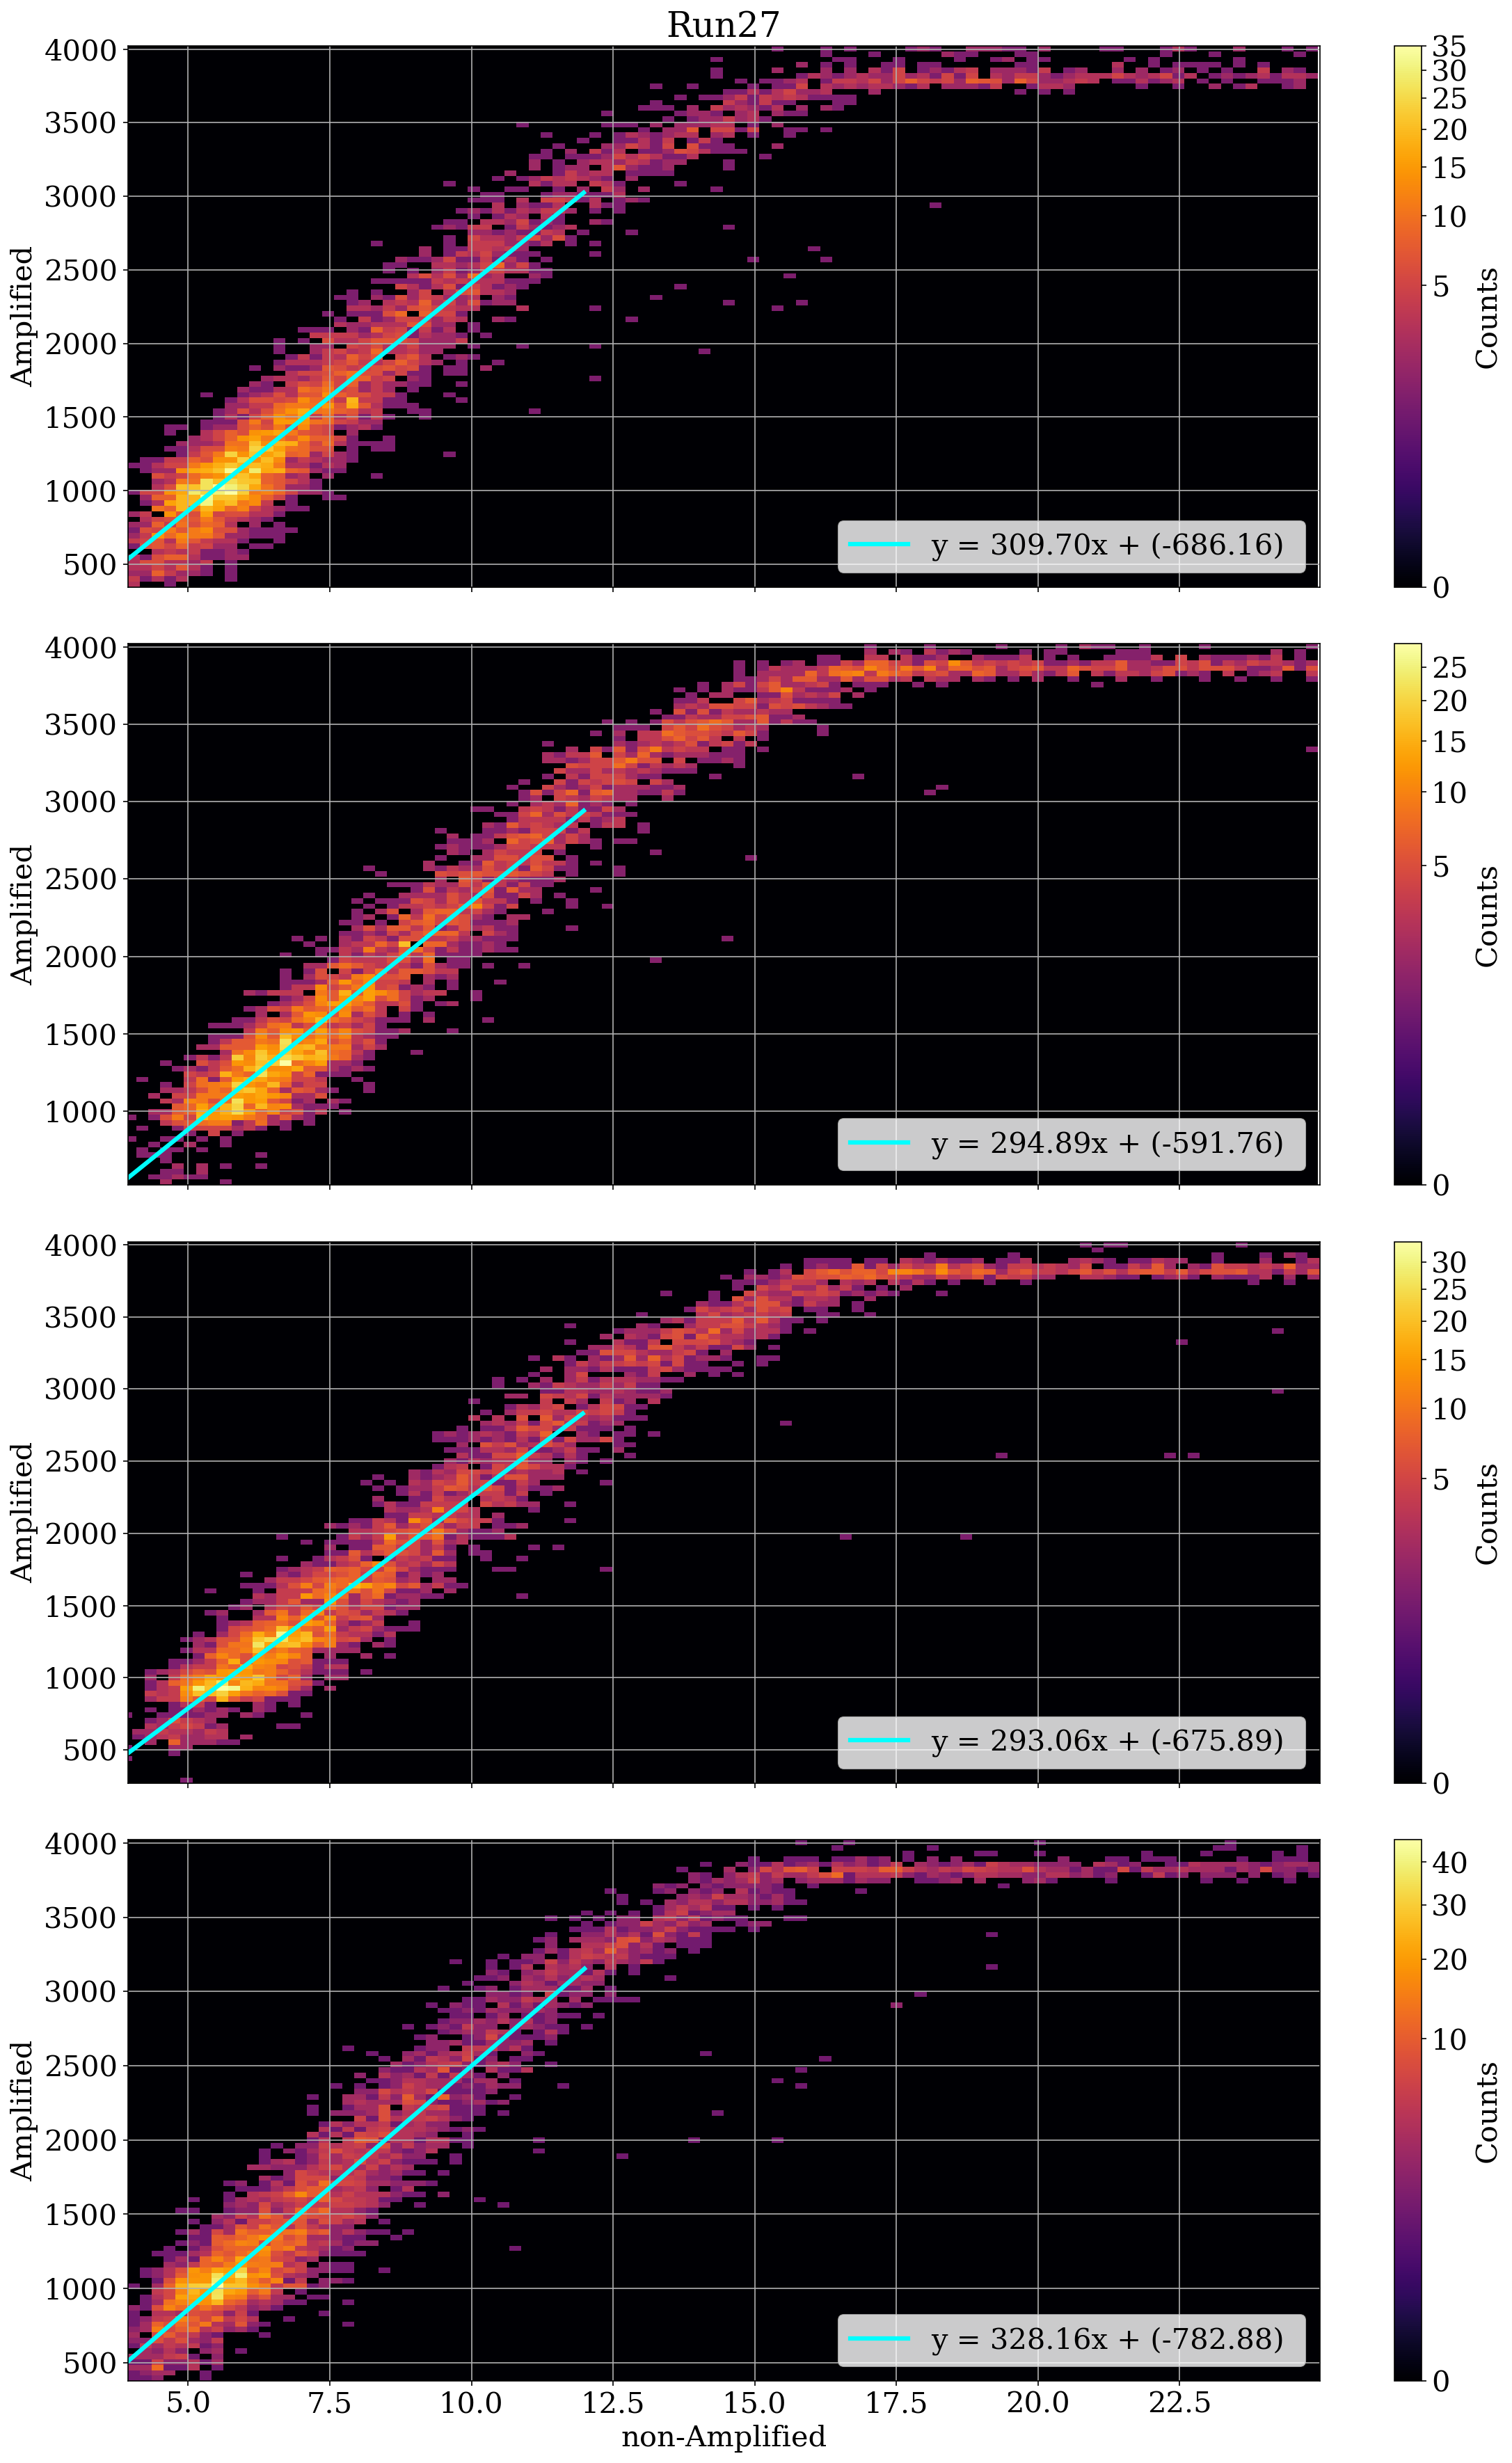

In [26]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')

amp_factors = {}

time    = filtered_df['TIME'].values
amp     = {}

# define the range of x (noAmp_amplitude) to include
# x_min, x_max = 0, 20
x_min, x_max = -1000, 25

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    # v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    # v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    # _, baselines_corrected_noAmp, _ = cig.BaselineCorrection(v_matrix_corrected_noAmp, window=window_width)
    # _, baselines_corrected_Amp, _       = cig.BaselineCorrection(v_matrix_corrected_Amp, window=window_width)

    # noAmp_amplitude   = v_matrix_corrected_noAmp.max(axis=1) - baselines_corrected_noAmp # (nevents,)
    # Amp_amplitude     = v_matrix_corrected_Amp.max(axis=1) - baselines_corrected_Amp # (nevents,)

    noAmp_amplitude   = v_matrix_noAmp.max(axis=1) - v_matrix_noAmp.min(axis=1) # (nevents,)
    Amp_amplitude     = v_matrix_Amp.max(axis=1) - v_matrix_Amp.min(axis=1) # (nevents,)

    # mask the data to include only that x-range
    mask = (noAmp_amplitude >= x_min) & (noAmp_amplitude <= x_max)
    x_vals = noAmp_amplitude[mask]
    y_vals = Amp_amplitude[mask]

    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(x_vals, y_vals, bins=[100, 100], 
                #    range=[[x_min, x_max], [y_vals.min(), y_vals.max()]],
                   range=[[x_vals.min(), x_vals.max()], [y_vals.min(), y_vals.max()]],
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    # Fit line
    fit_mask = (x_vals >= x_min) & (x_vals <= 12)
    # fit_mask = (x_vals >= x_min) & (x_vals <= 100)
    xx = x_vals[fit_mask]
    yy = y_vals[fit_mask]

    m, b = np.polyfit(xx, yy, 1)

    amp_factors[f'CH{i+1}'] = (m, b)

    x_fit = np.linspace(xx.min(), xx.max(), 200)
    y_fit = m * x_fit + b
    r = np.corrcoef(xx, yy)[0, 1]

    ax.plot(x_fit, y_fit, 'cyan', lw=3, label=f'y = {m:.2f}x + ({b:.2f}) ')



    ax.set_ylabel(f'Amplified')
    ax.grid(True)
    ax.legend(loc = 'lower right')

    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(0, 4000)

if len(all_channels) > 1:
    axs[-1].set_xlabel('non-Amplified')
else:
    ax.set_xlabel('non-Amplified')

# Improve layout
plt.tight_layout()
plt.show()

##  Gain comparisson

In [ ]:
len(amp_factors['CH1'][1] )

NameError: name 'amp_factors' is not defined

In [ ]:
# amp_factors = {'CH1':269,
#                'CH2':267,
#                'CH3':258,
#                'CH4':275
#                }

# amp_factors = {'CH1':277,
#                'CH2':269,
#                'CH3':263,
#                'CH4':284
#                }

temperature = f'{8}deg'

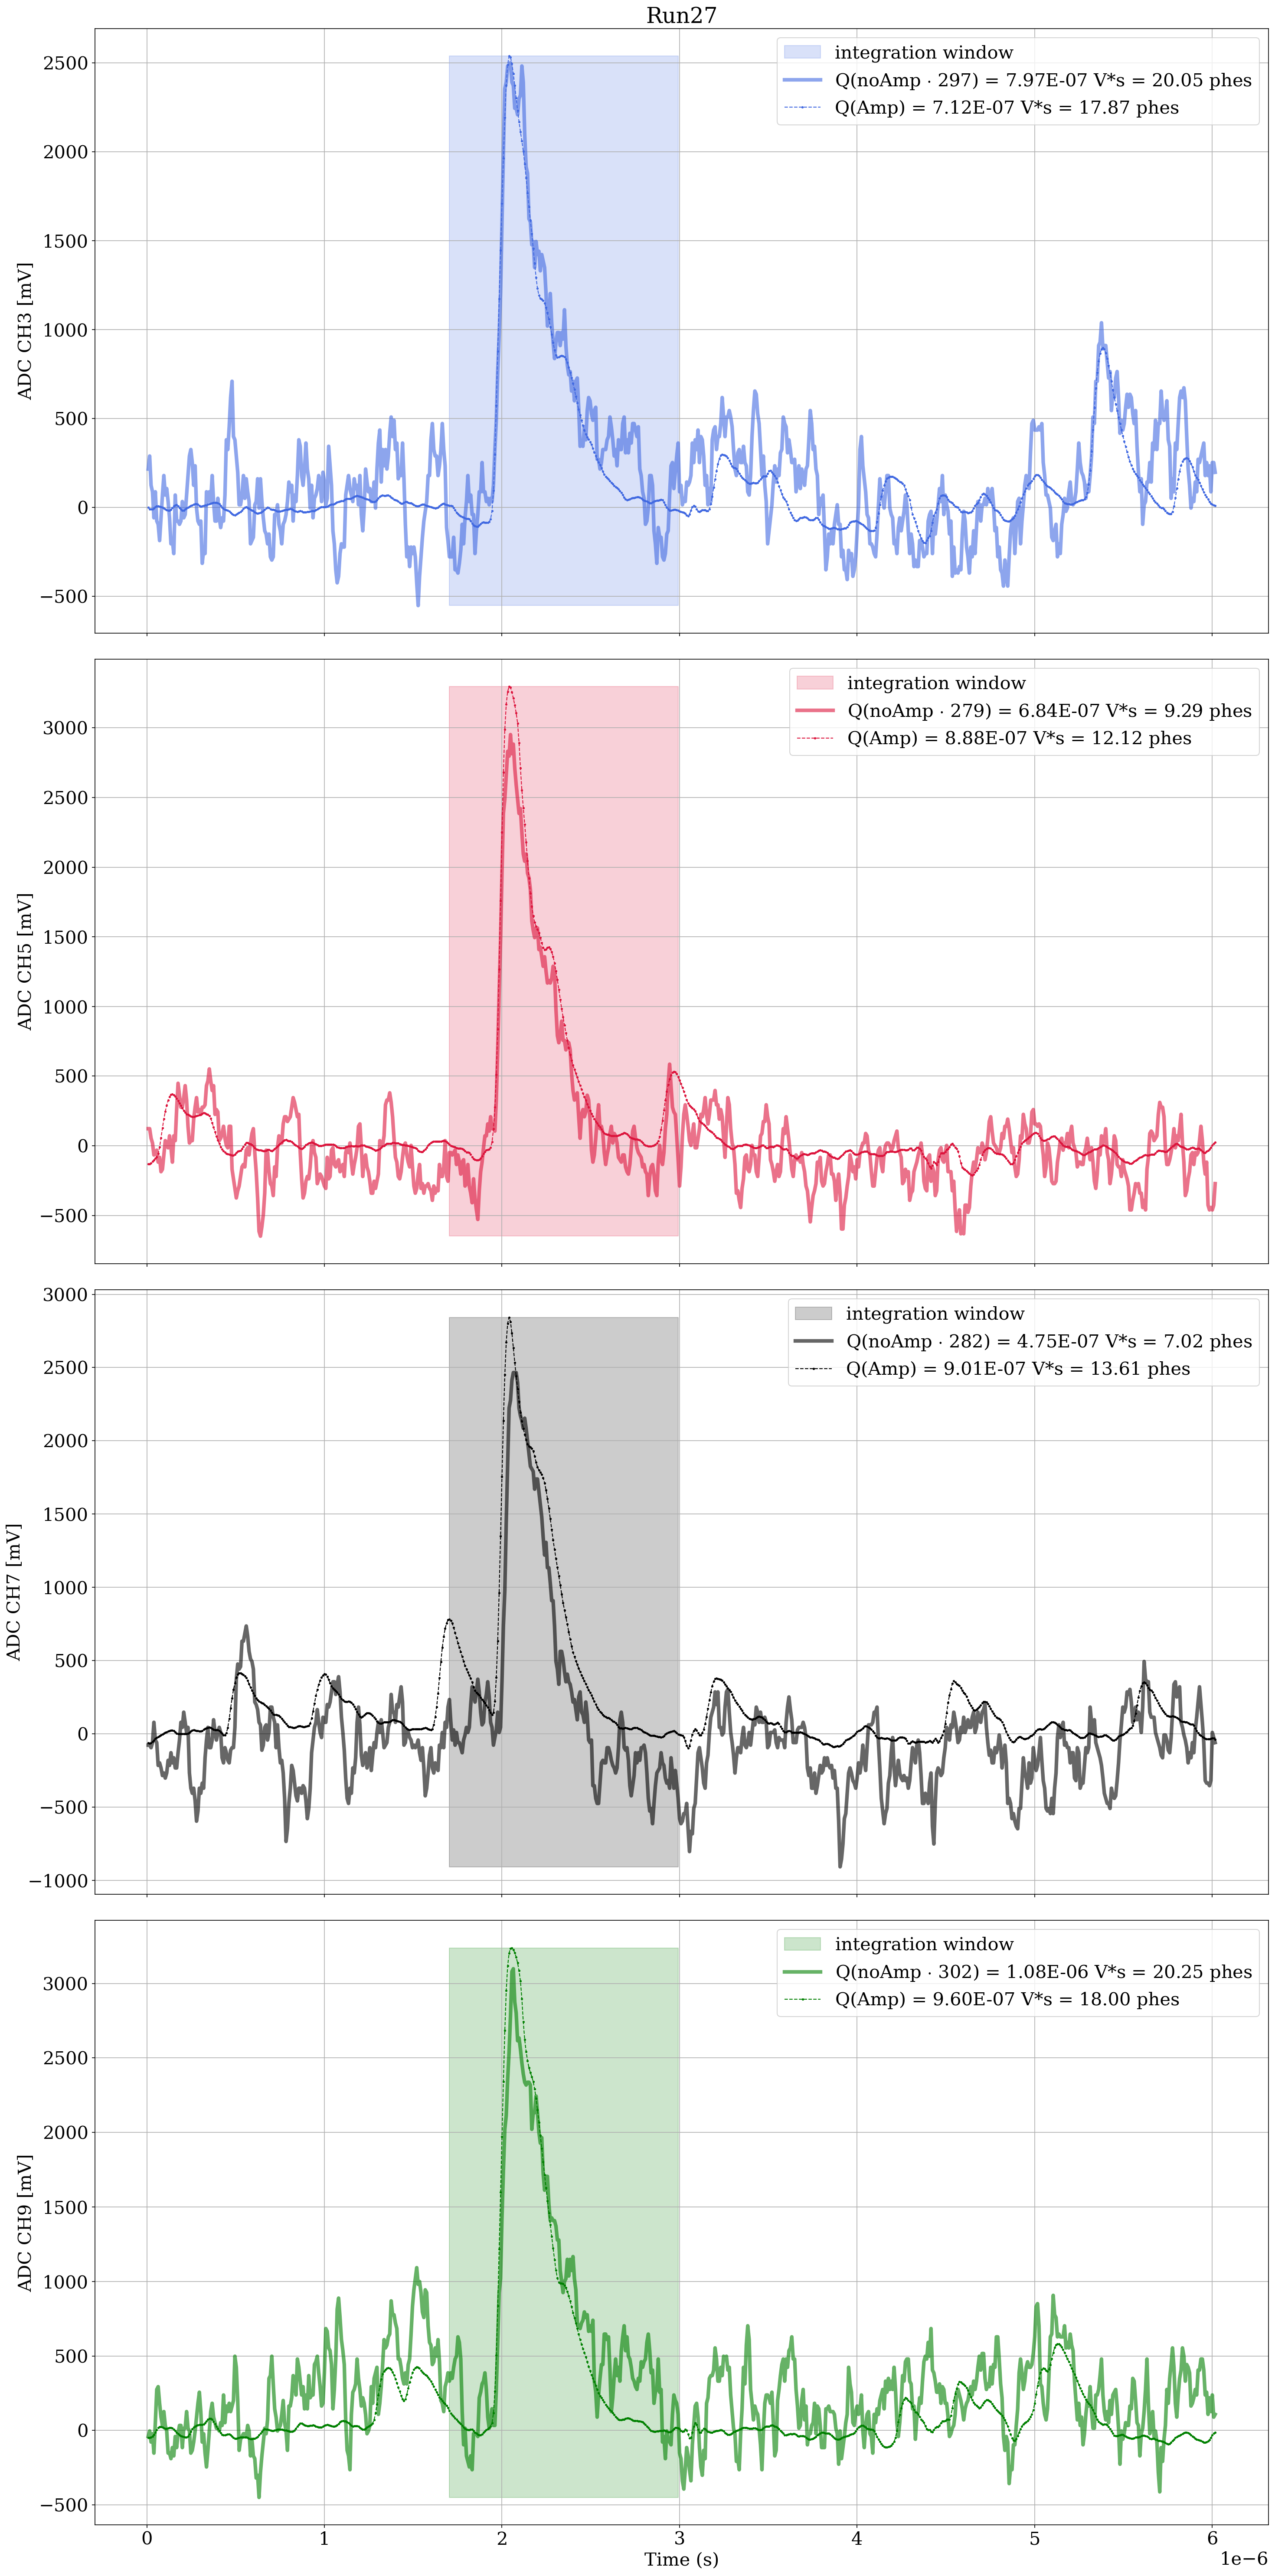

In [ ]:


if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(20, len(Amp_channels)*10), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    v_noAmp = v_matrix_corrected_noAmp[selected_ev]
    v_Amp   = v_matrix_corrected_Amp[selected_ev]
    t = t_matrix[selected_ev]

    time_window = (1.7e-6 < t)  & (3e-6 > t)

    charge_noAmp = np.trapz(v_noAmp[time_window]*1e-3, 
                            x = t[time_window])
    charge_Amp = np.trapz(v_Amp[time_window]*1e-3, 
                            x = t[time_window])
    
    charge_noAmp_phes = cig.ChargeToPes(charge_noAmp, channel=i+1, temp = temperature, amplified = False, CHAmp=amp_factors)
    charge_Amp_phes = cig.ChargeToPes(charge_Amp, channel=i+1, temp = temperature, amplified = True, CHAmp=amp_factors)
    
    ax.fill_between(t[time_window], 
                    min(v_Amp.min(), (v_noAmp*amp_factors[f'CH{i+1}']).min()), 
                    max(v_Amp.max(), (v_noAmp*amp_factors[f'CH{i+1}']).max()), 
                    color = colors[i], alpha = 0.2, label = 'integration window')


    ax.plot(t_matrix[selected_ev], amp_factors[f'CH{i+1}']*v_noAmp, marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, label=fr"Q(noAmp $\cdot$ {amp_factors[f'CH{i+1}']:.0f}) = {(amp_factors[f'CH{i+1}']*charge_noAmp):.2E} V*s = {charge_noAmp_phes:.2f} phes")
    ax.plot(t_matrix[selected_ev], v_Amp, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'Q(Amp) = {charge_Amp:.2E} V*s = {charge_Amp_phes:.2f} phes')
    


    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()